# HW6: Neural Network (Due May 22)


#### Please restart the kernel and run all before you submit. 


#### Name:  Eric Chi


There are several goals of this HW:

1. You can implement fully connected neural network (FNN) and convolutional neural network (CNN) using Python.

2. We want to verify that CNN works better than FNN in image classification task.

3. We want to analyze how the neural network structure and batch_size affect the test accuracy. 

Remark: There are many factors affecting the test performance. Due to the computation limitation, I cannot analyze all of them. 

**You are allowed to use either Tensorflow or PyTorch. If you fail to install modules, feel free to use Google Colab.**

**Important remark: Your grader will not run your code this time since it is time consuming. Please restart the kernel and run all before you submit, and make sure that your plot is visible on Gradescope.**

## Import all required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Load CIFAR10 Data

Load training and test samples from cifar10 dataset. Then normalize pixel values to be between 0 and 1 by dividing 255.0.

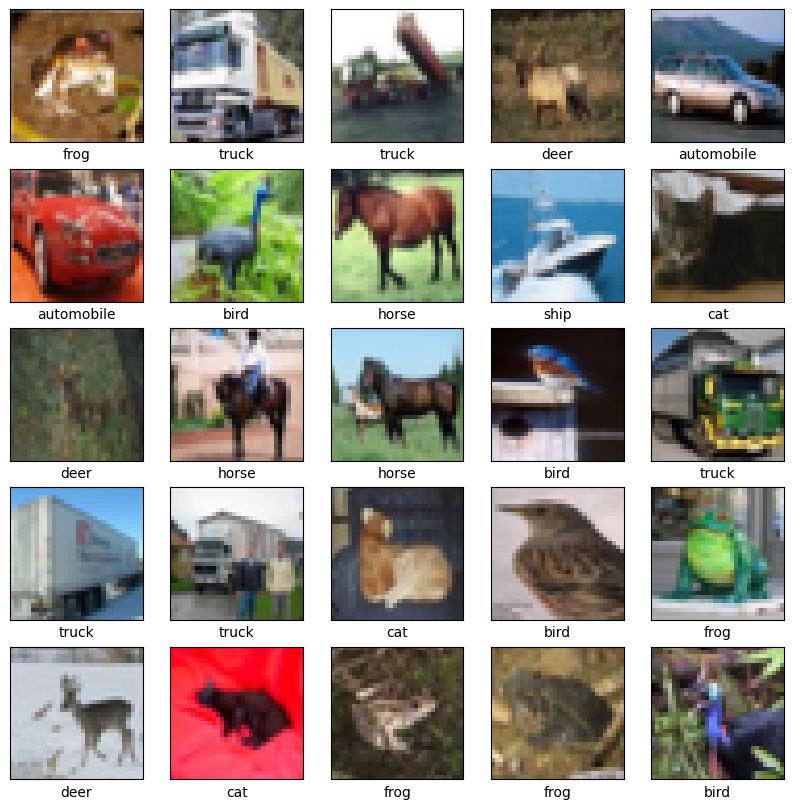

In [2]:
#Loadign CIFAR10 data and normalizing by dividing by 255
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


#just to check if CIFAR10 data was correctly defined.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Data preparation for fully connected neural networks

Before we use convolutional neural network for image classification task, people used fully connected neural networks. In this section, we will prepare the data for FNN.

To implement FNN, we require a dataset which is a 2D numpy array where each row represents each sample and each column is a features. For image dataset, we will have 3D numpy array (grey images) or 4D numpy array (color images). Our goal is to reshaping 3D/4D numpy array to 2D numpy array such that each row is one image and columns are pixel values.

Simplification: For grey images, you can assume the shape is (m,d1,d2) where m is the number of images, d1 and d2 are the numbers of pixels on each side. For color images, you can assume the shape is (m,d1,d2,r) where m, d1, d2 have the same meaning as before and r is the number of color channels (usually r=3 or 4).

Please write a function to do this step. Your function should work for all image datasets (both grey and color images). Detailed docstring is required to explain your function. You must include the shape of your inputs and outputs when you write the docstring.

Some test codes are given to verify your codes.

**Later, you will use the function you write to generate inputs that is used to train your FNN models.**

In [3]:
def reshape_images(images):
    """
    Reshape a 3D or 4D numpy array into a 2D numpy array.

    Args:
        images (ndarray): The input numpy array of shape (m, d1, d2) for grey images or (m, d1, d2, r) for color images.

    Returns:
        ndarray: The reshaped numpy array of shape (m, d1 * d2 * r) for color images or (m, d1 * d2) for grey images.
    """
    # Get the shape of the input array
    shape = images.shape

    # Reshape the array based on the number of color channels
    if len(shape) == 3:  # Grey images
        m, d1, d2 = shape
        reshaped_images = images.reshape(m, d1 * d2)
    elif len(shape) == 4:  # Color images
        m, d1, d2, r = shape
        reshaped_images = images.reshape(m, d1 * d2 * r)
    else:
        raise ValueError("Invalid input shape. Expected 3D or 4D numpy array.")

    return reshaped_images


In [4]:
# test example 1:
X1 = np.arange(24).reshape(3,2,4)

X1_reshaped = reshape_images(X1)

# Passing X1 to your function will return 
# array([[ 0,  1,  2,  3,  4,  5,  6,  7],
#        [ 8,  9, 10, 11, 12, 13, 14, 15],
#        [16, 17, 18, 19, 20, 21, 22, 23]])

X1_reshaped

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23]])

In [5]:
# test example 2:
X2 = np.arange(48).reshape(3,2,4,2)

# Passing X2 to your function will return 
# array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
#        [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
#        [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]])

X2_reshaped = reshape_images(X2)
X2_reshaped

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]])

In [6]:
# test example 3:
X_train = reshape_images(train_images)
idx = 1
np.allclose(X_train[1], train_images[1].flatten())

# let me explain this example further,
# train_images is the training images obtained from loading CIFAR10 data
# passing train_images to the function gives X_train.
#
#
# Notice that X_train and train_images are variables I defined, you may have different names.
# image_reshape is my function, you may also have different function name
# 
# Once you adjust variable names and function names, there is no error raised
# the output of this test example is True


True

## Construct your FNN model

In this section, you will construct a fully connected neural network. You only need to create the model by calling `tensorflow.models.Sequential` (other methods are also acceptable), and you do not need to train the model.

**Model:** This Neural network contains three hidden layers with number of neurons 50, 50, 50, respectively. The activation function is ReLU and you should use "he_normal" initialization for all hidden layers. 

You should determine the number of neurons in the input layer and output layer and report the total number of parameters.

In [7]:
#For a FNN we needed to flatten our data
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Define the model
FNN = Sequential()

# Add the layers to the model
FNN.add(Dense(50, activation='relu', kernel_initializer='he_normal', input_shape=(x_train_flat.shape[1],)))
FNN.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
FNN.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
FNN.add(Dense(10, activation='softmax'))

# Print the summary of the model
FNN.summary()


/Users/ericchi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │       153,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,260 (622.11 KB)

 Trainable params: 159,260 (622.11 KB)

 Non-trainable params: 0 (0.00 B)

## Construct your CNN models

In this section, you will construct two convolutional neural networks. You do not need to train the models. Just define them using `tensorflow.models.Sequential`.

I do not have any instructions on the cnstruction of your models. You should define two models and your models should be different. Feel free to change the neural network structure, kernel size, number of neurons, and etc. Please do not use very complicated model, you will reach computation limitation. Your model should be different from the model in my lecture notes.

**Suggestion**: It is better to think about a question first, and then determine model structure. For example, suppose you want to understand how the number of convolution layers affects the test accuracy, then you can define two models which contain different numbers of convolution layers. To make the comparison fair, you should make other factors the same. Try to think about the question you are interested in and design the models.


In [8]:
from tensorflow.keras import layers, models

# Define the CNN model
CNN1 = models.Sequential()

# Add the layers to the model
CNN1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
CNN1.add(layers.MaxPooling2D((2, 2)))
CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN1.add(layers.MaxPooling2D((2, 2)))
CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output from the convolutional layers
CNN1.add(layers.Flatten())

# Add fully connected layers
CNN1.add(layers.Dense(64, activation='relu'))
CNN1.add(layers.Dense(10, activation='softmax'))

# Print the summary of the model
CNN1.summary()


# Define the new CNN model
CNN2 = models.Sequential()

# Add the layers to the model
CNN2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Conv2D(128, (3, 3), activation='relu')) #this is the main change in the model

# Flatten the output from the convolutional layers
CNN2.add(layers.Flatten())

# Add fully connected layers
CNN2.add(layers.Dense(128, activation='relu')) #along with this
CNN2.add(layers.Dense(10, activation='softmax'))

# Print the summary of the model
CNN2.summary()




/Users/ericchi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

CNN1 = Sequential()
CNN1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
CNN1.add(layers.MaxPooling2D((2, 2)))
CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN1.add(layers.MaxPooling2D((2, 2)))
CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))


CNN1.

## Train your model

In this part, you should write a function to train your models. Your function should take the model, training samples, test samples, and batch_size as inputs and returns test accuracy after each epoch. Detailed function docstring is required. Your function should not include any global variables.

Comments:
1. Since this is a classification problem, you can use the same loss function and metric for all different models. You should determine the loss function and metric.

2. Please use epochs=5, otherwise it takes long to train your models.


In [9]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=5, batch_size=16):
    """
    Train a model and output the test accuracy after training.

    Args:
        model (keras.models.Model): The model to train.
        x_train (ndarray): The input training data.
        y_train (ndarray): The target training data.
        x_test (ndarray): The input test data.
        y_test (ndarray): The target test data.
        epochs (int): The number of epochs to train the model.
        batch_size (int): The batch size to use during training.

    Returns:
        list: The test accuracy after each epoch.
    """
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    test_accuracy = []  # List to store test accuracy for each epoch

    for epoch in range(epochs):
        # Train the model for one epoch
        model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0)

        # Evaluate the model on the test data
        _, acc = model.evaluate(x_test, y_test, verbose=0)
        test_accuracy.append(acc)

    return test_accuracy


## Numeircal experiments:

Now we can do our numerical experiments. Remember that we have three models (1 FNN, 2 CNNs), You should try different batch sizes and optimizers for each model, see below:

- Batch_size = 16 or 64.

Now, we have 6 different combinations. Please visualize all test accuracies in 1 plot. See my sample plot below. 


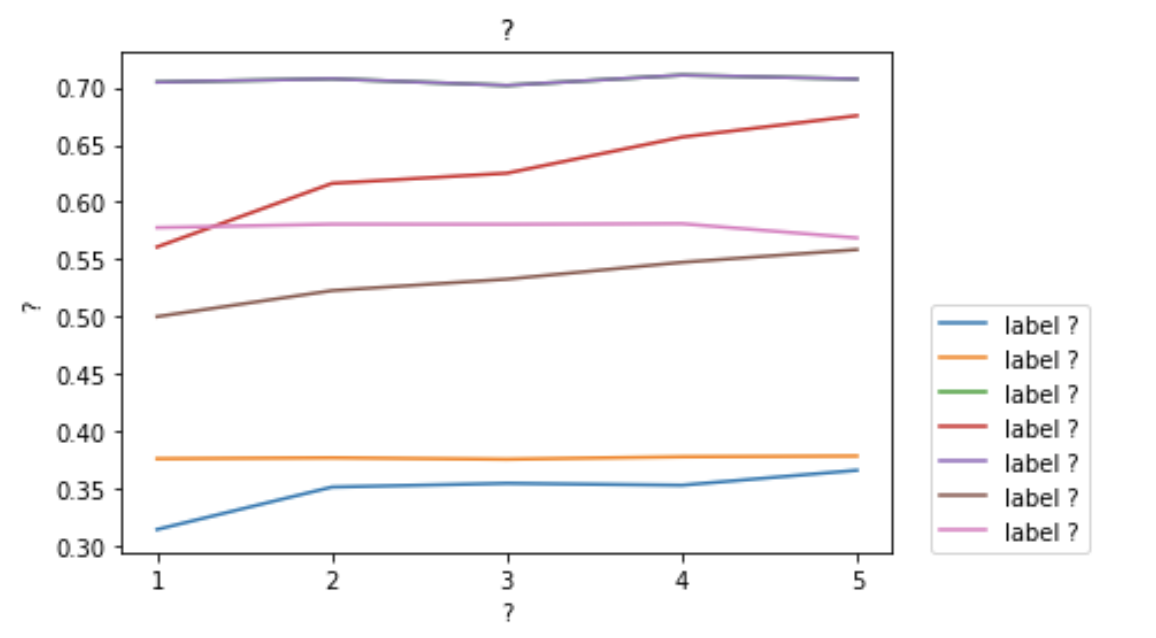

I do not have any legends, labels, title, and etc in my plot, you should include informative legends, labels, title, and etc. You can also add other features (e.g. markers) to create nice plot. You are welcome to use either matplotlib or seaborn to draw your plot.


**Important remark: It takes me 14 minutes to train 6 models. If your training time is longer than you expect, please try to use simple CNN models.** 



In [10]:
#training FNN
FNN16 = train_model(FNN, x_train_flat, y_train, x_test_flat, y_test, 5, 16)
FNN64 = train_model(FNN, x_train_flat, y_train, x_test_flat, y_test, 5, 64)


In [11]:
CNN116 = train_model(CNN1, train_images, train_labels, test_images, test_labels, 5, 16)
CNN164 = train_model(CNN1, train_images, train_labels, test_images, test_labels, 5, 64)
CNN216 = train_model(CNN1, train_images, train_labels, test_images, test_labels, 5, 16)
CNN264 = train_model(CNN2, train_images, train_labels, test_images, test_labels, 5, 64)


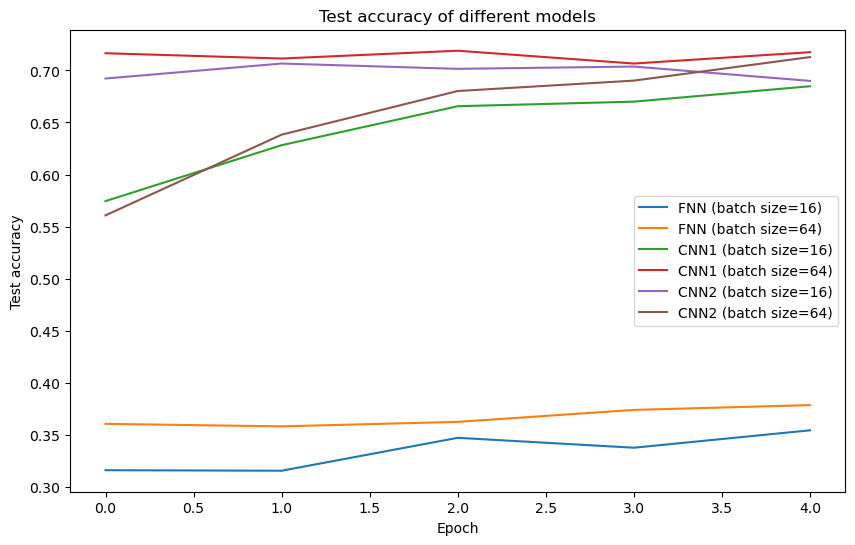

In [12]:
#plotting all the results in a line plot
plt.figure(figsize=(10, 6))
plt.plot(FNN16, label='FNN (batch size=16)')
plt.plot(FNN64, label='FNN (batch size=64)')
plt.plot(CNN116, label='CNN1 (batch size=16)')
plt.plot(CNN164, label='CNN1 (batch size=64)')
plt.plot(CNN216, label='CNN2 (batch size=16)')
plt.plot(CNN264, label='CNN2 (batch size=64)')
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.title('Test accuracy of different models')
plt.legend()
plt.show()

## Repeate your experiments:

Since there is randomness in your experiment such as the random initialization of your parameters (`he_normal`) and random shuffle of your dataset (`model.fit`), we usually repeat previous experiments many times and compute the mean to alleviate the randomness. We can also compute the standard deviation to measure the variation. We expect small standard deviation and it means that randomness in your experiment does not change your test accuracy too much.

You may notice that training CNN is time consuming. To save your time, we will do this part only for FNN. 

Please repeat your previous experiments 5 times for your FNN model. Specifically, you should repeat the following process 5 times: create your FNN model, select batch_size = 16/64, train your model and record test accuracy. 

Then, compute average test accuracy (1 decimal place) and standard deviation (1 decimal places) after each epoch and fill in the following table. 

In ths following table, 67.1% is the average test accuracy, 5.1% is the standard deviation. You should replace them using the data you compute. I only use those numbers to generate this template, and they do not have any real meaning.

|                      |   Epoch 1    |   Epoch 2    |   Epoch 3    |   Epoch 4    |   Epoch 5    |
|:--------------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
|    batch_size = 16   |67.1%$\pm$5.1%|67.1%$\pm$5.1%|67.1%$\pm$5.1%|67.1%$\pm$5.1%|67.1%$\pm$5.1%|
|    batch_size = 64   |67.1%$\pm$5.1%|67.1%$\pm$5.1%|67.1%$\pm$5.1%|67.1%$\pm$5.1%|67.1%$\pm$5.1%|


In [13]:
def repeat_experiment(model_constructor, x_train, y_train, x_test, y_test, epochs = 5, batchsize = 16, n = 5):
    """
    Repeat the experiment of training a model multiple times and return the test accuracy after each epoch for each run.

    Args:
        model_constructor (function): The function that constructs the model.
        x_train (ndarray): The input training data.
        y_train (ndarray): The target training data.
        x_test (ndarray): The input test data.
        y_test (ndarray): The target test data.
        epochs (int): The number of epochs to train the model.
        batchsize (int): The batch size to use during training.
        n (int): The number of times to repeat the experiment.

    Returns:
        list of np array: A np of test accuracy after each epoch for each run.
    """
    test_accuracies = np.zeros((n, epochs))  # List to store test accuracy for each run

    for i in range(n):
        model = model_constructor()
        model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

        class TestCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                _, accuracy = model.evaluate(x_test, y_test, verbose=0)
                test_accuracies[i, epoch] = accuracy
        
        model.fit(x_train, y_train, epochs = epochs, batch_size = batchsize, callbacks = [TestCallback()], verbose = 0)


    mean_accuracy = np.mean(test_accuracies, axis = 0)
    std_accuracy = np.std(test_accuracies, axis = 0)

    return mean_accuracy, std_accuracy

def model_constructor():
    """
    Constructs a neural network model for classification.
    
    Returns:
    model (Sequential): The constructed model.
    """

    # Define the model
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal', input_shape=(x_train_flat.shape[1],)))
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation='softmax'))

    return model

mean_accuracy16, std_accuracy16 = repeat_experiment(model_constructor, x_train_flat, y_train, x_test_flat, y_test, 5, 16, 5)

mean_accuracy64, std_accuracy64 = repeat_experiment(model_constructor, x_train_flat, y_train, x_test_flat, y_test, 5, 64, 5)

In [14]:
print(f"mean accuracy batch 16 {mean_accuracy16}")
print(f"mean accuracy batch 64 {mean_accuracy64}")
print(f"std accuracy batch 16 {std_accuracy16}")
print(f"std accuracy batch 64 {std_accuracy64}")


mean accuracy batch 16 [0.34497999 0.35248001 0.365      0.376      0.37951999]
mean accuracy batch 64 [0.3554     0.3777     0.39440001 0.40762    0.41046   ]
std accuracy batch 16 [0.01367704 0.01552358 0.02361228 0.0216086  0.02443509]
std accuracy batch 64 [0.01273688 0.00842164 0.01724494 0.01962594 0.01609032]


|                      |   Epoch 1    |   Epoch 2    |   Epoch 3    |   Epoch 4    |   Epoch 5    |
|:--------------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
|    batch_size = 16   |mean:34.5% std:1.4%|mean:35.2% std:1.6%|mean:36.5% std:2.4%|mean:37.6% std:2.2%|mean:38.0% std:2.4%|
|    batch_size = 64   |mean:35.5% std:1.3%|mean:37.8% std:0.8%|mean:39.4% std:1.7%|mean:40.8% std:2.0%|mean:41.0% std:1.6%|

## Conclusion:

Please list at least 3 informative conclusions based on your numerical results

1) The first conclusion I can make is that the higher batch size of 64 lead to better test accuracy all along the board of each of the models. Even though this is usually not the case, for this certain question. This may be due to the reduction in noise done while training which smaller batch sizes may bring. In the past we found that smaller batchsizes help in accuracy but for this certain problem we found that this is not the case

2) In terms of comparing CNN and FNN, for an image classification problem a CNN is way better than an FNN. This is the case due to CNN being able to capture the spatial hierarchy in an image such as edges and the layers of the photo. THere is also an efficiency in learning that CNN allows for as it has deeper learning with fewer parameters and fewer epochs. This helps in computational time and cost.

3) although I utlized different layers of the CNN by the end of the 5th epoch the results were pretty much the same. This can be due to the complexity of the problem and what CNN is utlized for, being decently good at image classification